In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler


# Data Cleaning

In [1]:

# Load the original data
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/30910 - June 2024.xlsx'
original_data = pd.read_excel(file_path, sheet_name='report - 2024-07-02T112453.993', header=4)
original_data = original_data.dropna(how='all').reset_index(drop=True)

# Clean up the column names
original_data.columns = [
    "Date", "Order_Number", "PO_Number", "Cost_Centre_Number",
    "Cost_Centre_Name_Delivery_Address", "NaN1", "Product",
    "Description", "Qty", "Process_Charge", "Domestic_Charge",
    "International_Charge", "Total_Charge", "No_of_Parcels",
    "Weight", "Cubic", "Con_Number", "Delivery_Courier"
]

# Drop unnecessary columns
original_data_cleaned = original_data.drop(columns=["NaN1", "Description","Cost_Centre_Number"])

# Convert necessary columns to numeric types
numeric_columns = ["Weight", "Cubic", "Process_Charge", "Domestic_Charge", "International_Charge", "Total_Charge", "No_of_Parcels"]
for column in numeric_columns:
    original_data_cleaned[column] = pd.to_numeric(original_data_cleaned[column], errors='coerce').fillna(0)

In [2]:
# Function to concatenate matching order numbers and preserve all metadata correctly
def concatenate_and_preserve_all_metadata(df):
    result = []
    seen = set()
    
    for idx, row in df.iterrows():
        order_num = row['Order_Number']
        if order_num not in seen:
            matched_rows = df[df['Order_Number'] == order_num]
            products = ', '.join(matched_rows['Product'].dropna().unique())
            total_qty = matched_rows['Qty'].sum()
            
            # Ensure matched_rows is not empty before accessing elements
            if not matched_rows.empty:
                if 'DIG OPTIONS' in matched_rows['Cost_Centre_Name_Delivery_Address'].values:
                    cost_centre_address = matched_rows['Cost_Centre_Name_Delivery_Address'].iloc[-1]
                else:
                    cost_centre_address = matched_rows['Cost_Centre_Name_Delivery_Address'].iloc[0]
            else:
                cost_centre_address = None
            
            new_row = row.copy()
            new_row['Product'] = products
            new_row['Qty'] = total_qty
            new_row['Cost_Centre_Name_Delivery_Address'] = cost_centre_address
            
            try:
                # Preserve metadata with first non-null value or sum where appropriate
                new_row['Date'] = matched_rows['Date'].dropna().iloc[0] if not matched_rows['Date'].dropna().empty else None
                new_row['Weight'] = matched_rows['Weight'].sum()
                new_row['Cubic'] = matched_rows['Cubic'].sum()
                new_row['Con_Number'] = matched_rows['Con_Number'].dropna().iloc[0] if not matched_rows['Con_Number'].dropna().empty else None
                new_row['Delivery_Courier'] = matched_rows['Delivery_Courier'].dropna().iloc[0] if not matched_rows['Delivery_Courier'].dropna().empty else None
                new_row['Total_Charge'] = matched_rows['Total_Charge'].sum()
                new_row['Process_Charge'] = matched_rows['Process_Charge'].sum()
                new_row['Domestic_Charge'] = matched_rows['Domestic_Charge'].sum()
                new_row['International_Charge'] = matched_rows['International_Charge'].sum()
                new_row['No_of_Parcels'] = matched_rows['No_of_Parcels'].sum()
            except Exception as e:
                print(f"Error processing order number {order_num}: {e}")
                continue
            
            result.append(new_row)
            seen.add(order_num)
    
    return pd.DataFrame(result)

# Apply the function to concatenate matching orders and preserve all metadata
final_data = concatenate_and_preserve_all_metadata(original_data_cleaned)

# Drop any remaining rows with invalid data in key columns
final_data = final_data.dropna(subset=['Order_Number', 'Cost_Centre_Name_Delivery_Address', 'Product', 'Qty'])

In [3]:
final_data

,Date,Order_Number,PO_Number,Cost_Centre_Name_Delivery_Address,Product,Qty,Process_Charge,Domestic_Charge,International_Charge,Total_Charge,No_of_Parcels,Weight,Cubic,Con_Number,Delivery_Courier
1,2024-06-03,1313257.0,HIAU24786/155546,"Attn: VIN HEM Phone: 0461231222, ,6 SHEPLEY CR...",HXS-102,1.0,8.45,8.13,0.0,16.58,1.0,0.3,1.0,M7U5159210,eParcel
3,2024-06-03,1313278.0,HIAU24789/155680,"Attn: CHRIS BORRETT Phone: +61448999859, ,21 S...",HXS-015,1.0,7.25,12.56,0.0,19.81,1.0,0.3,1.0,M7U5159212,eParcel
5,2024-06-03,1313271.0,HIAU24788/155622,"Attn: MATT PEET Phone: 0466 802 808, ,32 AUDRE...",HI-108B,1.0,7.25,12.56,0.0,19.81,1.0,0.2,1.0,M7U5159216,eParcel
7,2024-06-03,1313258.0,DIG1049218/,"Attn: GARY BOND Phone: 0403470352, GARY BOND,1...","TR80-SMEX3-BLK, TR80-FS05",3.0,14.15,15.35,0.0,29.50,3.0,12.0,3.0,3303211313258,Direct Freight Express
10,2024-06-03,1313274.0,07-11642-45983/,"Attn: NEVILLE DEUIS Phone: +61 418 498 912, ,1...",TP-10S,4.0,8.00,9.73,0.0,17.73,1.0,0.1,1.0,M7U5159223,eParcel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,2024-06-28,1317272.0,TRAU49280-W6/160160,"Attn: DANIEL KAMFER Phone: +61397938111, DANIE...","TR80-NEWPB, TR120-SMEX, SA-06, TR120-BLK-PART1...",10.0,32.15,104.03,0.0,136.18,10.0,82.0,10.0,3303211317272,Direct Freight Express
3031,2024-06-28,1317294.0,TRAU49186/159733,"Attn: JAMES TURNER Phone: +61397938111, ,6 STO...",TR80-SCREWNUT2,3.0,14.15,9.54,0.0,23.69,1.0,0.6,1.0,M7U5160898,eParcel
3033,2024-06-28,1317269.0,TRAU49276-W6/160152,"Attn: LUKE Phone: +61415139648, ,12 Benedict C...",TR-TRX-SING,1.0,6.50,14.13,0.0,20.63,1.0,5.0,1.0,M7U5160899,eParcel
3035,2024-06-28,1317270.0,TRAU49277-W6/160153,"Attn: TIM BOYD Phone: +61397938111, ,1 NESTAN ...","RS6-06-B-PART1, RS6-06-B-PART2, SA-09, TR-WKIT...",5.0,17.90,40.78,0.0,58.68,5.0,51.0,5.0,3303211317270,Direct Freight Express


In [4]:
# Sum the charges and create a summary table
charge_columns = ["Process_Charge", "Domestic_Charge", "International_Charge", "Total_Charge"]
summary_table = final_data[charge_columns].sum().reset_index()
summary_table.columns = ["Charge Type", "Total Amount"]

print(summary_table)

            Charge Type  Total Amount
0        Process_Charge      11072.10
1       Domestic_Charge      24371.00
2  International_Charge        120.48
3          Total_Charge      35563.58


Mapping Function to have the states

In [5]:
# State name mapping
state_name_mapping = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'TAS': 'Tasmania',
    'ACT': 'Australian Capital Territory',
    'WA': 'Western Australia',
    'SA': 'South Australia',
    'NT': 'Northern Territory',
    'New Zealand' : 'New Zealand'
}

In [6]:
def map_state(address):
    for abbr, full_name in state_name_mapping.items():
        if abbr in address:
            return full_name
    return "Unknown"

# Apply the mapping function to the address column
final_data['State'] = final_data['Cost_Centre_Name_Delivery_Address'].apply(map_state)

# Print the first few rows to verify the new State column
print(final_data.head())

         Date  Order_Number         PO_Number  \
1  2024-06-03     1313257.0  HIAU24786/155546   
3  2024-06-03     1313278.0  HIAU24789/155680   
5  2024-06-03     1313271.0  HIAU24788/155622   
7  2024-06-03     1313258.0       DIG1049218/   
10 2024-06-03     1313274.0   07-11642-45983/   

                    Cost_Centre_Name_Delivery_Address  \
1   Attn: VIN HEM Phone: 0461231222, ,6 SHEPLEY CR...   
3   Attn: CHRIS BORRETT Phone: +61448999859, ,21 S...   
5   Attn: MATT PEET Phone: 0466 802 808, ,32 AUDRE...   
7   Attn: GARY BOND Phone: 0403470352, GARY BOND,1...   
10  Attn: NEVILLE DEUIS Phone: +61 418 498 912, ,1...   

                      Product  Qty  Process_Charge  Domestic_Charge  \
1                     HXS-102  1.0            8.45             8.13   
3                     HXS-015  1.0            7.25            12.56   
5                     HI-108B  1.0            7.25            12.56   
7   TR80-SMEX3-BLK, TR80-FS05  3.0           14.15            15.35   
10     

In [8]:
final_data
# Save the final_data DataFrame to a CSV file
final_data.to_csv('States_Included.csv', index=False)


# International Price ( Outliers )

In [51]:
International = final_data[final_data['International_Charge'] > 0]

International

,Date,Order_Number,PO_Number,Cost_Centre_Name_Delivery_Address,Product,Qty,Process_Charge,Domestic_Charge,International_Charge,Total_Charge,No_of_Parcels,Weight,Cubic,Con_Number,Delivery_Courier,State
384,2024-06-06,1313918.0,TRNZ3056 -T/156283,"Attn: SCOTT DIXON Phone: 027 644 6815, ,C/O EB...","TR80-NWMDD, TR80-NWMA3",2.0,11.30,0.0,52.82,64.12,1.0,5.30,1.0,CH150671219AU,PACK AND TRACK,Northern Territory
903,2024-06-12,1314742.0,TRNZ3126/156558,"Attn: BEN CHRISTIAN Phone: 64275004040, ,49 MO...","TR80-JOINT, TR-SPMT-TR8020",2.0,11.30,0.0,31.58,42.88,1.0,2.30,1.0,CH150829994AU,PACK AND TRACK,New Zealand
1077,2024-06-14,1315154.0,TRNZ3127/157639,"Attn: JIMMY WONG Phone: 021 279 7947, ,7A UMER...",TR8WSLIDER,1.0,6.50,0.0,17.88,24.38,1.0,0.65,1.0,LH314738267AU,PACK AND TRACK,Northern Territory
2534,2024-06-25,1316695.0,TRNZ3128/159603,"Attn: BILL RYDER Phone: +64 21 424 507, 021424...",TR-TR8BLM4,1.0,8.45,0.0,18.20,26.65,1.0,0.70,1.0,LH316432280AU,PACK AND TRACK,New Zealand


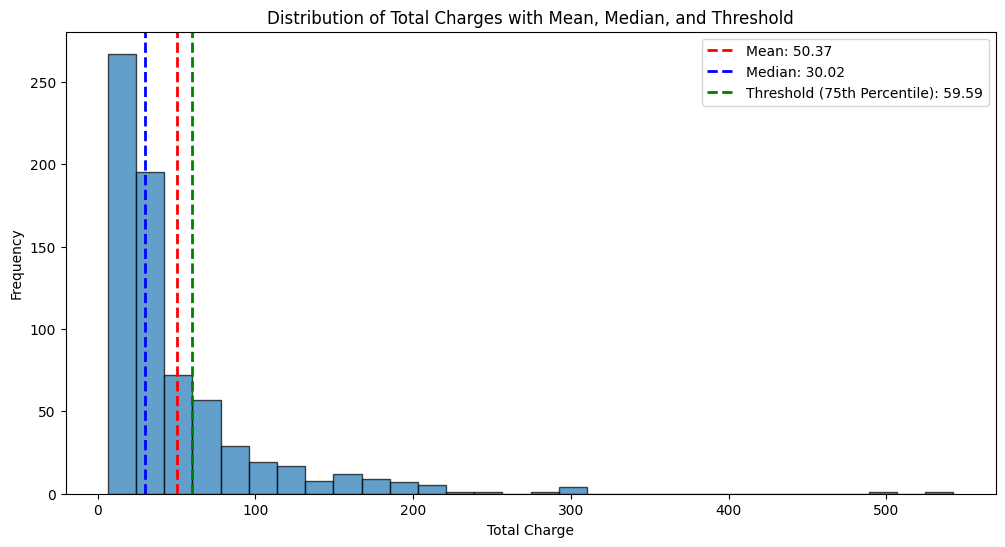

In [14]:
import matplotlib.pyplot as plt

# Calculate the threshold using the 75th percentile
threshold_75th = final_data['Total_Charge'].quantile(0.75)

# Create a new column to categorize orders as expensive or non-expensive
final_data['Expense_Category'] = final_data['Total_Charge'].apply(lambda x: 'Expensive' if x > threshold_75th else 'Non-Expensive')

# Calculate median
median_charge = final_data['Total_Charge'].median()

# Plot the histogram with mean and median lines
plt.figure(figsize=(12, 6))
plt.hist(final_data['Total_Charge'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(final_data['Total_Charge'].mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {final_data["Total_Charge"].mean():.2f}')
plt.axvline(median_charge, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median_charge:.2f}')
plt.axvline(threshold_75th, color='g', linestyle='dashed', linewidth=2, label=f'Threshold (75th Percentile): {threshold_75th:.2f}')
plt.title('Distribution of Total Charges with Mean, Median, and Threshold per Total Charge only')
plt.xlabel('Total Charge')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Delivery Corrier General

         Delivery_Courier  Total_Charge
2                     JET    155.346667
1  Direct Freight Express     73.277030
4                 PICK UP     43.980000
3          PACK AND TRACK     39.507500
7         eParcel EXPRESS     31.720000
6                 eParcel     22.423472
0                     DFE     20.850000
5                    WFDS     16.250000


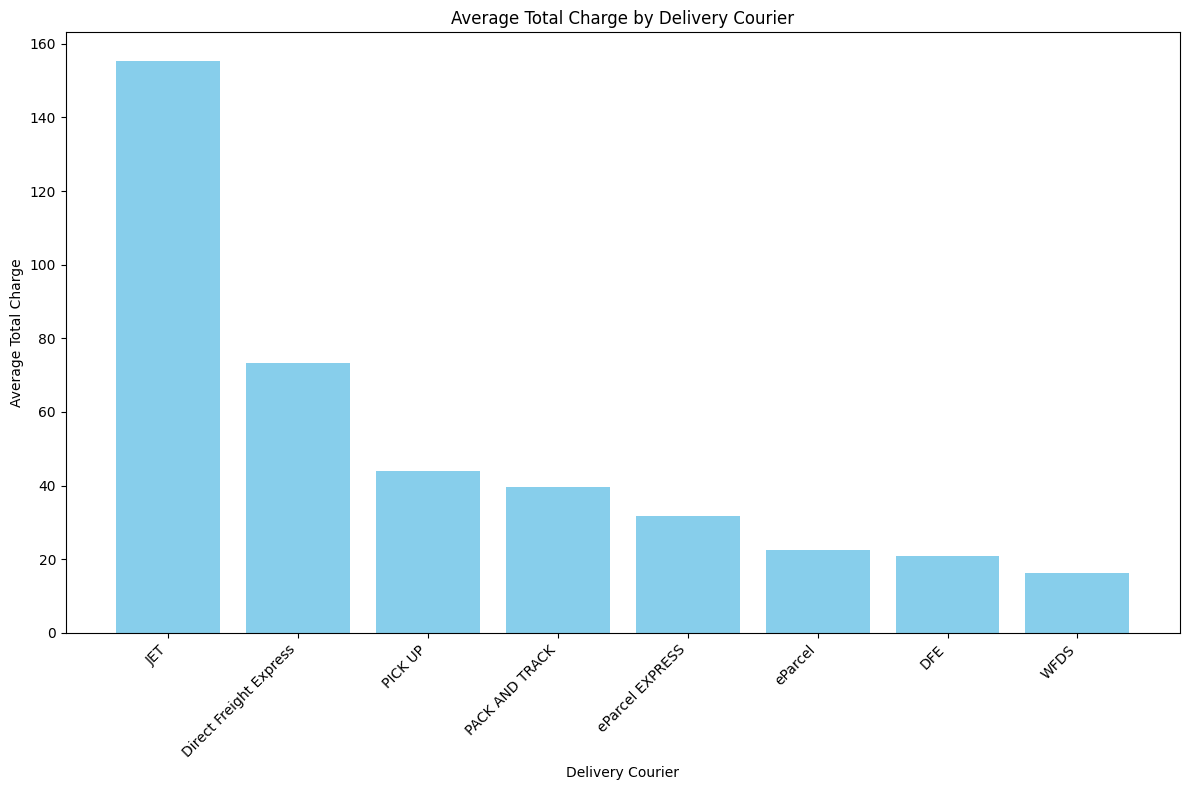

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Delivery_Courier and calculate the mean Total_Charge
courier_charge_correlation = final_data.groupby('Delivery_Courier')['Total_Charge'].mean().reset_index()

# Sort the data for better visualization
courier_charge_correlation = courier_charge_correlation.sort_values(by='Total_Charge', ascending=False)

# Display the correlation results
print(courier_charge_correlation)

# Visualize the correlation using a bar plot
plt.figure(figsize=(12, 8))
plt.bar(courier_charge_correlation['Delivery_Courier'], courier_charge_correlation['Total_Charge'], color='skyblue')
plt.title('Average Total Charge by Delivery Courier')
plt.xlabel('Delivery Courier')
plt.ylabel('Average Total Charge')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


         Delivery_Courier  Total_Charge
0  Direct Freight Express     86.948732
1                 eParcel     23.636731
2         eParcel EXPRESS     20.155000


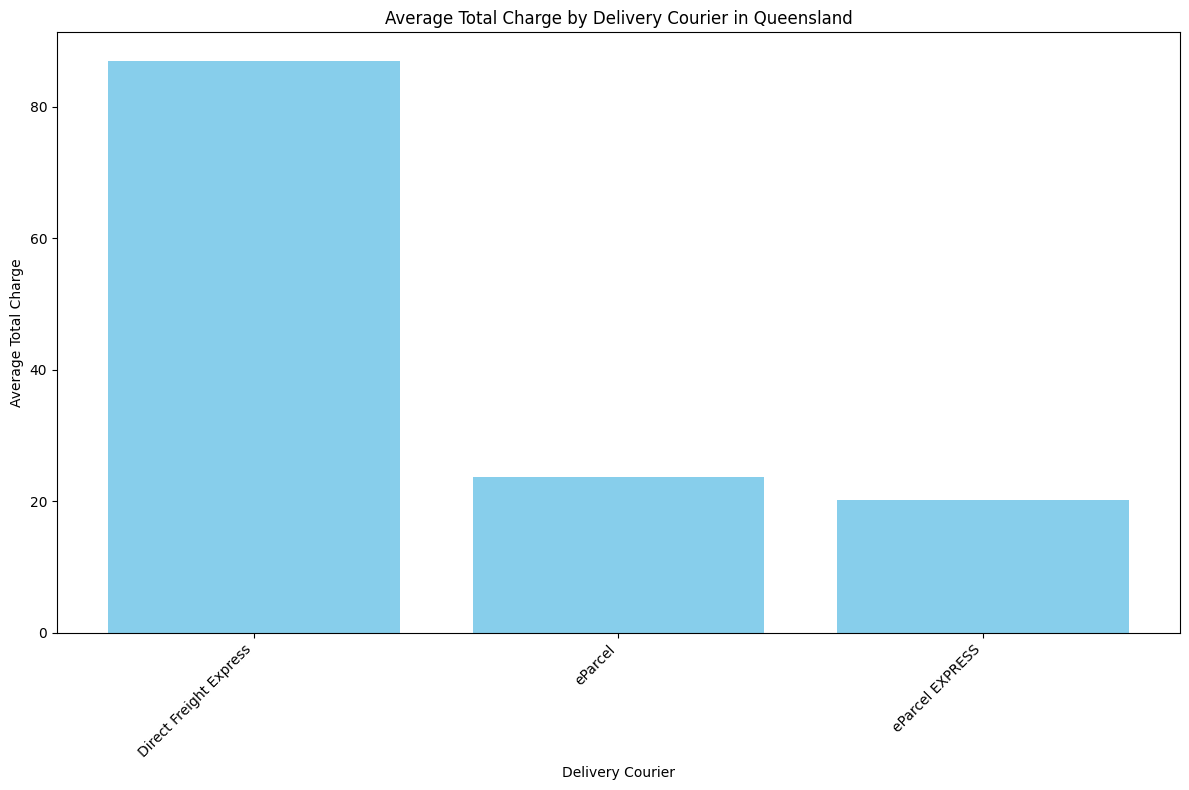

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Queensland only
queensland_data = final_data[final_data['State'] == 'Queensland']

# Group by Delivery_Courier and calculate the mean Total_Charge for Queensland only
courier_charge_correlation_queensland = queensland_data.groupby('Delivery_Courier')['Total_Charge'].mean().reset_index()

# Sort the data for better visualization
courier_charge_correlation_queensland = courier_charge_correlation_queensland.sort_values(by='Total_Charge', ascending=False)

# Display the correlation results for Queensland
print(courier_charge_correlation_queensland)

# Visualize the correlation using a bar plot
plt.figure(figsize=(12, 8))
plt.bar(courier_charge_correlation_queensland['Delivery_Courier'], courier_charge_correlation_queensland['Total_Charge'], color='skyblue')
plt.title('Average Total Charge by Delivery Courier in Queensland')
plt.xlabel('Delivery Courier')
plt.ylabel('Average Total Charge')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Queensland MAP

In [4]:
# Load your data (adjust the path as needed)
expensive_non_expensive_delivery_addresses = pd.read_excel('C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Final_Updated_Queensland_Orders_With_Cluster_4_Categorization.xlsx')



In [5]:
expensive_non_expensive_delivery_addresses

,Date,Order_Number,PO_Number,Cost_Centre_Name_Delivery_Address,Product,Qty,Process_Charge,Domestic_Charge,International_Charge,Total_Charge,No_of_Parcels,Weight,Cubic,Delivery_Courier,State,Category_4_Clusters
0,2024-06-03,1313257,HIAU24786/155546,"Attn: VIN HEM Phone: 0461231222, ,6 SHEPLEY CR...",HXS-102,1,8.45,8.13,0.0,16.58,1,0.3,1,eParcel,South Australia,NaN
1,2024-06-03,1313278,HIAU24789/155680,"Attn: CHRIS BORRETT Phone: +61448999859, ,21 S...",HXS-015,1,7.25,12.56,0.0,19.81,1,0.3,1,eParcel,New South Wales,NaN
2,2024-06-03,1313271,HIAU24788/155622,"Attn: MATT PEET Phone: 0466 802 808, ,32 AUDRE...",HI-108B,1,7.25,12.56,0.0,19.81,1,0.2,1,eParcel,Queensland,Not Expensive
3,2024-06-03,1313258,DIG1049218/,"Attn: GARY BOND Phone: 0403470352, GARY BOND,1...","TR80-SMEX3-BLK, TR80-FS05",3,14.15,15.35,0.0,29.50,3,12.0,3,Direct Freight Express,South Australia,NaN
4,2024-06-03,1313274,07-11642-45983/,"Attn: NEVILLE DEUIS Phone: +61 418 498 912, ,1...",TP-10S,4,8.00,9.73,0.0,17.73,1,0.1,1,eParcel,Queensland,Not Expensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,2024-06-28,1317272,TRAU49280-W6/160160,"Attn: DANIEL KAMFER Phone: +61397938111, DANIE...","TR80-NEWPB, TR120-SMEX, SA-06, TR120-BLK-PART1...",10,32.15,104.03,0.0,136.18,10,82.0,10,Direct Freight Express,Western Australia,NaN
702,2024-06-28,1317294,TRAU49186/159733,"Attn: JAMES TURNER Phone: +61397938111, ,6 STO...",TR80-SCREWNUT2,3,14.15,9.54,0.0,23.69,1,0.6,1,eParcel,New South Wales,NaN
703,2024-06-28,1317269,TRAU49276-W6/160152,"Attn: LUKE Phone: +61415139648, ,12 Benedict C...",TR-TRX-SING,1,6.50,14.13,0.0,20.63,1,5.0,1,eParcel,New South Wales,NaN
704,2024-06-28,1317270,TRAU49277-W6/160153,"Attn: TIM BOYD Phone: +61397938111, ,1 NESTAN ...","RS6-06-B-PART1, RS6-06-B-PART2, SA-09, TR-WKIT...",5,17.90,40.78,0.0,58.68,5,51.0,5,Direct Freight Express,Victoria,NaN


In [37]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import re

# Load your data
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Final_Updated_Queensland_Orders_With_Cluster_4_Categorization.xlsx'
queensland_data = pd.read_excel(file_path)

# Filter for Queensland orders
queensland_data = queensland_data[queensland_data['State'] == 'Queensland']

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to clean and extract address for geocoding
def extract_address(full_address):
    try:
        # Use regex to extract address components
        match = re.search(r',([^,]+),([^,]+),([^,]+),([^,]+)$', full_address)
        if match:
            street, suburb, state, country = match.groups()
            clean_address = f"{street}, {suburb}, {state}, {country}"
            return clean_address
        else:
            print(f"Failed to extract: {full_address}")
            return None
    except Exception as e:
        print(f"Error extracting address from {full_address}: {e}")
        return None

# Extract cleaned addresses
queensland_data['Clean_Address'] = queensland_data['Cost_Centre_Name_Delivery_Address'].apply(extract_address)

# Drop rows with failed address extraction
queensland_data = queensland_data.dropna(subset=['Clean_Address'])

# Function to geocode addresses with logging
def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            print(f"Geocoded: {address} => ({location.latitude}, {location.longitude})")
            return location.latitude, location.longitude
        else:
            print(f"Failed to geocode: {address}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Geocode the clean delivery addresses
queensland_data['Coordinates'] = queensland_data['Clean_Address'].apply(geocode_address)
queensland_data[['Latitude', 'Longitude']] = pd.DataFrame(queensland_data['Coordinates'].tolist(), index=queensland_data.index)

# Drop rows with NaN values in coordinates
queensland_data = queensland_data.dropna(subset=['Latitude', 'Longitude'])

# Check if there are valid coordinates to center the map
if not queensland_data.empty:
    map_center = [queensland_data['Latitude'].mean(), queensland_data['Longitude'].mean()]
else:
    # Default to a generic location if no valid coordinates are found
    map_center = [-27.470125, 153.021072]  # Coordinates for Brisbane, Queensland

# Create a map centered around the average location of the points
queensland_orders_map = folium.Map(location=map_center, zoom_start=6)

# Add markers to the map for each order
for _, row in queensland_data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        color = 'red' if row['Category_4_Clusters'] == 'Expensive' else 'green'
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Order Number: {row['Order_Number']}<br>PO Number: {row['PO_Number']}<br>Category: {row['Category_4_Clusters']}",
            icon=folium.Icon(color=color)
        ).add_to(queensland_orders_map)

# Save the map to an HTML file
queensland_orders_map.save('Queensland_Orders_Map.html')
print("Map has been saved to Queensland_Orders_Map.html")


Geocoded:  GRACEMERE, QLD, 4702, Australia => (-23.4576095, 150.453490522133)
Geocoded:  REDLAND BAY, QLD, 4165, Australia => (-27.6126945, 153.3036238)
Geocoded:  BELLMERE, QLD, 4510, Australia => (-27.0874616, 152.9229806)
Geocoded:  THORNLANDS, QLD, 4164, Australia => (-27.558201, 153.2666265)
Geocoded:  SOUTH MACKAY, QLD, 4740, Australia => (-21.1620812, 149.1880737)
Geocoded:  MOOROOKA, QLD, 4105, Australia => (-27.5357999, 153.0201543)
Geocoded:  NEW BEITH, QLD, 4124, Australia => (-27.761777000000002, 152.94009253395734)
Geocoded:  GLASS HOUSE MOUNTAINS, QLD, 4518, Australia => (-26.904301500000003, 152.93021765577274)
Geocoded:  GREENBANK, QLD, 4124, Australia => (-27.6928305, 152.96559891474107)
Geocoded:  WILSTON, QLD, 4051, Australia => (-27.4335826, 153.020154)
Geocoded:  ARUNDEL, QLD, 4214, Australia => (-27.9360655, 153.3653514)
Geocoded:  AVOCA, QLD, 4670, Australia => (-24.8835577, 152.3086117)
Geocoded:  REDBANK PLAINS, QLD, 4301, Australia => (-27.65142, 152.852108269

# Highlight Options

In [25]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Load the CSV file
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Logistic_Regression_Predictions.csv'
df = pd.read_csv(file_path)

# Define the output file path
output_file_path = file_path.replace('.csv', '.xlsx')

# Save the DataFrame to an XLSX file
df.to_excel(output_file_path, index=False, engine='openpyxl')

# Load the workbook and the specific sheet
wb = load_workbook(output_file_path)
ws = wb.active

# Define the colors
red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")
green_fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")

# Get the index of the 'Category_4_Clusters' column (1-based index for openpyxl)
category_col_idx = df.columns.get_loc('Predicted_Category_4_Clusters') + 1

# Apply the styling based on the value in 'Category_4_Clusters'
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    category_cell = row[category_col_idx - 1]  # Get the cell in the 'Category_4_Clusters' column
    if category_cell.value is not None:  # Check for non-null values
        if category_cell.value == 'Expensive':
            for cell in row:
                cell.fill = red_fill
        elif category_cell.value == 'Not Expensive':
            for cell in row:
                cell.fill = green_fill

# Save the workbook with the applied styles
wb.save(output_file_path)

print(f"File saved to {output_file_path} with highlighted rows")


File saved to C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Logistic_Regression_Predictions.xlsx with highlighted rows


In [6]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Load the CSV file
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Clusters.csv'
df = pd.read_csv(file_path)

# Define the output file path
output_file_path = file_path.replace('.csv', '.xlsx')

# Save the DataFrame to an XLSX file
df.to_excel(output_file_path, index=False, engine='openpyxl')

# Load the workbook and the specific sheet
wb = load_workbook(output_file_path)
ws = wb.active

# Define the colors
red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")
green_fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")

# Get the index of the 'Category_4_Clusters' column (1-based index for openpyxl)
category_col_idx = df.columns.get_loc('Category_4_Clusters') + 1

# Apply the styling based on the value in 'Category_4_Clusters'
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    category_cell = row[category_col_idx - 1]  # Get the cell in the 'Category_4_Clusters' column
    if category_cell.value is not None:  # Check for non-null values
        if category_cell.value == 'Expensive':
            for cell in row:
                cell.fill = red_fill
        elif category_cell.value == 'Not Expensive':
            for cell in row:
                cell.fill = green_fill

# Save the workbook with the applied styles
wb.save(output_file_path)

print(f"File saved to {output_file_path} with highlighted rows")


File saved to C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Clusters.xlsx with highlighted rows


# Final Price

In [ ]:
# Load the CSV file
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Take a look later on/products_export_1.csv'
df_final_price = pd.read_csv(file_path)
df_final_price

In [12]:
df_final_price.nunique()

Handle                          543
Title                           512
Body (HTML)                     448
Vendor                           22
Product Category                 12
                               ... 
Cost per item                     0
Included / Australia              1
Price / Australia                 0
Compare At Price / Australia      0
Status                            3
Length: 124, dtype: int64

# Whole Map

In [22]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import re

# Load your data
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Logistic_Regression_Predictions.csv'
data = pd.read_csv(file_path)

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to clean and extract address for geocoding
def extract_address(full_address):
    try:
        # Use regex to extract address components
        match = re.search(r',([^,]+),([^,]+),([^,]+),([^,]+)$', full_address)
        if match:
            street, suburb, state, country = match.groups()
            clean_address = f"{street}, {suburb}, {state}, {country}"
            return clean_address
        else:
            print(f"Failed to extract: {full_address}")
            return None
    except Exception as e:
        print(f"Error extracting address from {full_address}: {e}")
        return None

# Extract cleaned addresses
data['Clean_Address'] = data['Cost_Centre_Name_Delivery_Address'].apply(extract_address)

# Drop rows with failed address extraction
data = data.dropna(subset=['Clean_Address'])

# Function to geocode addresses with logging
def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            print(f"Geocoded: {address} => ({location.latitude}, {location.longitude})")
            return location.latitude, location.longitude
        else:
            print(f"Failed to geocode: {address}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Geocode the clean delivery addresses
data['Coordinates'] = data['Clean_Address'].apply(geocode_address)
data[['Latitude', 'Longitude']] = pd.DataFrame(data['Coordinates'].tolist(), index=data.index)

# Drop rows with NaN values in coordinates
data = data.dropna(subset=['Latitude', 'Longitude'])

# Check if there are valid coordinates to center the map
if not data.empty:
    map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
else:
    # Default to a generic location if no valid coordinates are found
    map_center = [-25.274398, 133.775136]  # Coordinates for Australia

# Create a map centered around the average location of the points
aus_orders_map = folium.Map(location=map_center, zoom_start=5)

# Add markers to the map for each order
for _, row in data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        color = 'red' if row['Predicted_Category_4_Clusters'] == 'Expensive' else 'green'
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Order Number: {row['Order_Number']}<br>PO Number: {row['PO_Number']}<br>Category: {row['Predicted_Category_4_Clusters']}",
            icon=folium.Icon(color=color)
        ).add_to(aus_orders_map)

# Save the map to an HTML file
aus_orders_map.save('AUS_Orders_Map.html')
print("Map has been saved to AUS_Orders_Map_Logistic_Regression.html")


Geocoded:  BURTON, SA, 5110, Australia => (-34.7377001, 138.6001346)
Geocoded:  MUSWELLBROOK, NSW, 2333, Australia => (-32.2675086, 150.8905694)
Geocoded:  GRACEMERE, QLD, 4702, Australia => (-23.4576095, 150.453490522133)
Geocoded:  OAKDEN, SA, 5086, Australia => (-34.8527761, 138.6432901)
Geocoded:  REDLAND BAY, QLD, 4165, Australia => (-27.6126945, 153.3036238)
Geocoded:  WATTLE GROVE, NSW, 2173, Australia => (-33.9564013, 150.9405862)
Geocoded:  URALLA, NSW, 2358, Australia => (-30.642884, 151.4993684)
Geocoded:  GOOGONG, NSW, 2620, Australia => (-35.422209, 149.2363805)
Geocoded:  ENDEAVOUR HILLS, VIC, 3802, Australia => (-37.9702665, 145.2563443)
Geocoded:  WANGARATTA, VIC, 3677, Australia => (-36.356434, 146.3228311)
Geocoded:  KELLYVILLE RIDGE, NSW, 2155, Australia => (-33.7025, 150.9186111)
Geocoded:  GOULBURN, NSW, 2580, Australia => (-34.7523871, 149.7198009)
Geocoded:  BELLMERE, QLD, 4510, Australia => (-27.0874616, 152.9229806)
Geocoded:  CROYDON, VIC, 3136, Australia => (

In [24]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import re

# Load your data
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Logistic_Regression_Predictions.csv'
data = pd.read_csv(file_path)

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to clean and extract address for geocoding
def extract_address(full_address):
    try:
        # Use regex to extract address components
        match = re.search(r',([^,]+),([^,]+),([^,]+),([^,]+)$', full_address)
        if match:
            street, suburb, state, country = match.groups()
            clean_address = f"{street}, {suburb}, {state}, {country}"
            return clean_address
        else:
            print(f"Failed to extract: {full_address}")
            return None
    except Exception as e:
        print(f"Error extracting address from {full_address}: {e}")
        return None

# Extract cleaned addresses
data['Clean_Address'] = data['Cost_Centre_Name_Delivery_Address'].apply(extract_address)

# Drop rows with failed address extraction
data = data.dropna(subset=['Clean_Address'])

# Function to geocode addresses with logging
def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            print(f"Geocoded: {address} => ({location.latitude}, {location.longitude})")
            return location.latitude, location.longitude
        else:
            print(f"Failed to geocode: {address}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Geocode the clean delivery addresses
data['Coordinates'] = data['Clean_Address'].apply(geocode_address)
data[['Latitude', 'Longitude']] = pd.DataFrame(data['Coordinates'].tolist(), index=data.index)

# Drop rows with NaN values in coordinates
data = data.dropna(subset=['Latitude', 'Longitude'])

# Check if there are valid coordinates to center the map
if not data.empty:
    map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
else:
    # Default to a generic location if no valid coordinates are found
    map_center = [-25.274398, 133.775136]  # Coordinates for Australia

# Create a map centered around the average location of the points
aus_orders_map = folium.Map(location=map_center, zoom_start=5)

# Add markers to the map for each order
for _, row in data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Ensure correct column name and condition
        if 'Predicted_Category_4_Clusters' in row and row['Predicted_Category_4_Clusters'] == 'Expensive':
            color = 'red'
        else:
            color = 'green'
        
        # Ensure correct columns are used for popup
        popup_text = (
            f"Order Number: {row['Order_Number']}<br>"
            f"Product: {row['Product']}<br>"
            f"Category: {row['Predicted_Category_4_Clusters']}<br>"
            f"Delivery Courier: {row['Delivery_Courier']}"
        )
        
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_text,
            icon=folium.Icon(color=color)
        ).add_to(aus_orders_map)

# Save the map to an HTML file
aus_orders_map.save('AUS_Orders_Map_Logistic_Regression.html')
print("Map has been saved to AUS_Orders_Map_Logistic_Regression.html")


Geocoded:  BURTON, SA, 5110, Australia => (-34.7377001, 138.6001346)
Geocoded:  MUSWELLBROOK, NSW, 2333, Australia => (-32.2675086, 150.8905694)
Geocoded:  GRACEMERE, QLD, 4702, Australia => (-23.4576095, 150.453490522133)
Geocoded:  OAKDEN, SA, 5086, Australia => (-34.8527761, 138.6432901)
Geocoded:  REDLAND BAY, QLD, 4165, Australia => (-27.6126945, 153.3036238)
Geocoded:  WATTLE GROVE, NSW, 2173, Australia => (-33.9564013, 150.9405862)
Geocoded:  URALLA, NSW, 2358, Australia => (-30.642884, 151.4993684)
Geocoded:  GOOGONG, NSW, 2620, Australia => (-35.422209, 149.2363805)
Geocoded:  ENDEAVOUR HILLS, VIC, 3802, Australia => (-37.9702665, 145.2563443)
Geocoded:  WANGARATTA, VIC, 3677, Australia => (-36.356434, 146.3228311)
Geocoded:  KELLYVILLE RIDGE, NSW, 2155, Australia => (-33.7025, 150.9186111)
Geocoded:  GOULBURN, NSW, 2580, Australia => (-34.7523871, 149.7198009)
Geocoded:  BELLMERE, QLD, 4510, Australia => (-27.0874616, 152.9229806)
Geocoded:  CROYDON, VIC, 3136, Australia => (

Logistic Regression for Classification

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load your data
file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Clusters.csv'
data = pd.read_csv(file_path)

# Prepare the feature matrix and target variable
features = ['Qty', 'Process_Charge', 'Domestic_Charge', 'International_Charge', 'Total_Charge', 'Weight']
X = data[features]
y = data['Category_4_Clusters'].map({'Expensive': 1, 'Not Expensive': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Print classification report
classification_report_log_reg = classification_report(y_test, y_pred)
print(classification_report_log_reg)

# Predict on the entire dataset
data['Predicted_Category_4_Clusters'] = log_reg.predict(X_scaled)
data['Predicted_Category_4_Clusters'] = data['Predicted_Category_4_Clusters'].map({1: 'Expensive', 0: 'Not Expensive'})

# Calculate the ratio of 'Expensive' orders per state
expensive_ratios_log_reg = data.groupby('State')['Predicted_Category_4_Clusters'].apply(lambda x: (x == 'Expensive').mean()).reset_index()
expensive_ratios_log_reg.columns = ['State', 'Expensive_Ratio']

print(expensive_ratios_log_reg)

# Save the output to a new CSV file
# output_file_path = 'C:/Users/olcay/Desktop/TASKS/TrakRacer/AUS Shipping Comparison/Updated_Data_with_Logistic_Regression_Predictions.csv'
# data.to_csv(output_file_path, index=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        36

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142

                          State  Expensive_Ratio
0  Australian Capital Territory         0.285714
1               New South Wales         0.176768
2                   New Zealand         1.000000
3            Northern Territory         0.600000
4                    Queensland         0.264000
5               South Australia         0.093023
6                      Tasmania         0.315789
7                      Victoria         0.250000
8             Western Australia         0.329897
